## Useful Functions

#### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from laserembeddings import Laser
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import math
from tqdm import tqdm
import translators as ts
from langdetect import detect

[nltk_data] Downloading package stopwords to C:\Users\asus-
[nltk_data]     zen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### To sum numbers in a string

In [2]:
def sum_numbers_in_string(text):
  """
  This function sums all the numbers present in a string.

  Args:
      text: The string containing numbers.

  Returns:
      The sum of all the numbers in the string. If no numbers are found, returns 0.
  """
  total_sum = 0
  current_number = ""
  for char in text:
    if char.isdigit():
      current_number += char
    else:
      if current_number:
        total_sum += int(current_number)
        current_number = ""
  # Add the last number if it exists
  if current_number:
    total_sum += int(current_number)
  return total_sum

# Example usage
string = "This is 10 a test string with 2 numbers 3 and 7."
sum_of_numbers = sum_numbers_in_string(string)
print(f"The sum of all numbers in the string is: {sum_of_numbers}")

The sum of all numbers in the string is: 22


#### Last-K Cosine Similarities Sliding Window Functions

In [3]:
#Return the average cosine similarity between the last k embeddings
def average_k_cosine_similarity(embeddings, k):
    tmp_similarity = []
    for i in np.arange(k):
        if i != k-1:
            tmp_similarity.append(np.dot(embeddings[k-1], embeddings[i]) / (np.linalg.norm(embeddings[k-1]) * np.linalg.norm(embeddings[i])))
    return np.mean(tmp_similarity)

def cosine_similarities_last_k_sliding_window (embeddings2, k):
    trial_similarities = list()
    for i in np.arange(len(embeddings2)-k):
        window = [emb for emb in embeddings2[i:i+k]]
        trial_similarities.append(average_k_cosine_similarity(window, k))
    return trial_similarities

In [4]:
def watch_messages_in_a_range(messages, start, end, k):
    for i in np.arange(start, end):
        print(str(i) +" : " + messages[i+k])

#To find a suitable treshold for the cosine similarity method
def find_suitable_treshold(similarities, df):
    treshold = 0
    numofindices = 0
    totconv = totconversations(df)
    while(numofindices < totconv):
        indices = [i for i, num in enumerate(similarities) if num < treshold]
        numofindices = len(indices)
        treshold = treshold + 0.001
    return treshold

In [5]:
#Printing some info to understand the results of the cosine similarities method
def cosine_similarities_info(df, similarities, treshold, k):
    print("treshold = " + str(treshold))
    indices = [i+k for i, num in enumerate(similarities) if num < treshold]
    #minindex = min(enumerate(our_group_similarities.min()))
    minimum = [i for i, num in enumerate(similarities) if num == min(similarities)]
    print("\nIndex with the minimum cosine similarity: ")
    print(minimum)
    print("\nIndices with cosine similarity below the treshold:")
    print(indices)
    print("\nNumber of Indices Below the Treshold:")
    print(len(indices))
    print("\nNumber of Conversations in the dataframe:")
    print(totconversations(df))
    cos_indices = df.iloc[indices]
    print("\nNumber of different conversations discovered by the method:")
    print(totconversations(cos_indices))
    print("\nAccuracy:")
    print(str(totconversations(cos_indices)/totconversations(df)) + " %")

#### Merge Consecutive Messages from the same user

In [6]:
# Function to merge consecutive messages from the same sender in a dataframe if they are sent within a certain time frame
def merge_consecutive_messages(df,timeframe):
    ourdf = df.copy()
    k = ourdf.shape[0]-1
    i=0
    c = 0
    cons_messages_indx = []
    merged_idxs=[]
    while i < k-1:
        ourdf.reset_index(drop=True, inplace=True)
        j=i+1
        delta_timestamp = (ourdf.iloc[j]['date']-ourdf.iloc[i]['date']).seconds
        if(not math.isnan(ourdf.iloc[i]['sender'] )):
            while(ourdf.iloc[i]['sender'] == ourdf.iloc[j]['sender'] and delta_timestamp<timeframe and (ourdf.iloc[j]['reply'] == ourdf.iloc[i]['reply'] or math.isnan(ourdf.iloc[j]['reply'])) and ourdf.iloc[j]['conversation_id'] == ourdf.iloc[i]['conversation_id']):
                cons_messages_indx.append(c)
                cons_messages_indx.append(c+1)
                text = str(ourdf.iloc[i]['text']) + ". " + str(ourdf.iloc[j]['text'])
                ourdf.at[i, 'text'] = text
                ourdf.at[i,'reactions'] = ourdf.iloc[j]['reactions'] + ourdf.iloc[i]['reactions']
                
                ourdf.drop(j, inplace=True)
                ourdf.reset_index(drop=True, inplace=True)
                merged_idxs.append(i)
                k = k-1
                c = c+1
        i=i+1
        c = c+1
    return ourdf, cons_messages_indx, merged_idxs

#### To Achieve LASER Embeddings

In [7]:
#Use 'en' for english and 'it' for italian as language
def embed_dataframe(df, language):
    langs = [language for i in range(len(df['text']))]
    laser = Laser()
    embeddings = laser.embed_sentences(df['text'], lang=langs)
    return embeddings

def embed_messages(messages, language):
    langs = [language for i in range(len(messages))]
    laser = Laser()
    embeddings = laser.embed_sentences(messages, lang=langs)
    return embeddings

#### For Statitstics

In [8]:
#To count the number of reactions in the dataframe
def countreactions(df):
    return df['reactions'].apply(lambda x: sum_numbers_in_string(x)).sum()

#To count the number of different conversations in the dataframe
def totconversations(df):
    return df.groupby('conversation_id').count().shape[0]

#To compute the mean length of the conversations in the dataframe
def meanconversationlength(df):
    return df.shape[0] / totconversations(df)

#To count the number of messages per group in the dataframe
def messagespergroup(df):
    return df.groupby('group')['group'].count()

#To count the number of conversations per group in the dataframe
def conversationspergroup(df):
    convpergroup = df.groupby(['group','conversation_id'])['conversation_id'].size()
    return convpergroup.groupby('group').count()

#To compute the mean length of the conversations per group in the dataframe
def lengthofconversationspergroup(df):
    return messagespergroup(df)/conversationspergroup(df)

def printstatistics(predf):
    pd.set_option('display.max_rows', None)
    print("Total Number of Conversations:")
    print(totconversations(predf))
    print("\nTotal Number of Messages:")
    print(predf.shape[0])
    print("\nTotal Number of Reactions:")
    print(countreactions(predf))
    print("\nMessages per Conversation in average:")
    print(meanconversationlength(predf))
    print("\nConversations per group:")
    convpergroup = conversationspergroup(predf)
    print(convpergroup)

    # First plot
    plt.figure()
    colors = plt.cm.viridis(np.linspace(0, 1, len(convpergroup)))
    convpergroup.plot(kind='bar', title='#Conversations per group', color=colors)
    plt.show()  # Display the first plot

    print("Messages per Conversations per Group in Average:")
    locpergroup = lengthofconversationspergroup(predf)
    print(locpergroup)

    plt.figure()
    colors = plt.cm.viridis(np.linspace(0, 1, len(locpergroup)))
    locpergroup.plot(kind='bar', title='#Messages per Conversations per Group in Average', color=colors)
    plt.show()  # Display the first plot

#### For Pre-Processing

In [9]:

def preprocess_message(message):
  
  # Removing mentions
  message = re.sub(r"@\w+", "", message)
  # Removing links
  message = re.sub(r"(\[[^\]]+\]|https?://[^\s]+)", "", message)
  # Removing newlines
  message = re.sub(r"\n", " ", message)
  # Removing special characters
  #message = re.sub(r"[^\w\s]", " ", message)

  # Convert to lowercase
  #message = message.lower()

  # Removing empty words
  message = " ".join(message.split())

  return message

# example
messaggi = ["Ciao a tutti!", "Come va?", "Oggi è una bella giornata\n.", " "]
preprocessed_messages = [preprocess_message(message) for message in messaggi]
print(preprocessed_messages)

['Ciao a tutti!', 'Come va?', 'Oggi è una bella giornata .', '']


In [10]:
def remove_stopwords(message, language):
  # Get the stopwords for the specified language
  stop_words = set(stopwords.words(language))
  # Split the message into words
  words = message.split()
  # Remove the stopwords
  words = [word for word in words if word not in stop_words]
  # Join the words back into a single string
  return " ".join(words)


# example
messaggi = ["Ciao a tutti!", "Come va?", "Oggi è una bella giornata\n."]
preprocessed_messages = [remove_stopwords(message,"italian") for message in messaggi]
print(preprocessed_messages)

['Ciao tutti!', 'Come va?', 'Oggi bella giornata .']


In [11]:
def remove_stopwords_from_messages(messages, language):
  return [remove_stopwords(message, language) for message in messages]

In [12]:
def prerprocess_messages(messages):
    return [preprocess_message(message) for message in messages]

In [13]:
def translate_messages(df_original):
    import translators as ts
    translation_text_google = []
    df_translated = df_original.copy()
    for i in tqdm(range(len(df_translated))):
        try:
            original_text = df_translated['text'].iloc[i]
            detected_language = detect(original_text)
            if detected_language != 'en':
                message_google = ts.translate_text(query_text=original_text, translator='google', from_language='auto', to_language='en')
                translation_text_google.append(message_google)
            else:
                translation_text_google.append(original_text)
        except:
            translation_text_google.append(original_text)

    df_translated['text'] = translation_text_google
    return df_translated

In [14]:
def translate_texts(texts):
    translation_text_google = []
    for i in np.arange(len(texts)):
        try:
            original_text = texts[i]
            detected_language = detect(original_text)
            if detected_language != 'en':
                message_google = ts.translate_text(query_text=original_text, translator='google', from_language='auto', to_language='en')
                translation_text_google.append(message_google)
            else:
                translation_text_google.append(original_text)
        except:
            translation_text_google.append(original_text)

    return translation_text_google

## Telegram Message Dataset Description

This dataset was collected by reading 300 messages from 7 different Telegram groups (2100 Messages).

### Data Fields:
- **ID:** A unique identifier for each message.
- **Group:** The name or identifier of the Telegram group from which the message originated.
- **Sender:** The username or identifier of the person who sent the message.
- **Text:** The content of the message.
- **Reply:** The ID of the message to which the current message is a reply (if applicable).
- **Date:** The date and time when the message was sent.
- **Reactions:** Information about any reactions (e.g., likes, emojis) received by the message.

### Manual Labeling:
Each conversation has been manually labeled to differentiate it from others using the "conversation_id" label.

This dataset provides a comprehensive view of interactions within various Telegram groups, allowing for analysis of communication patterns, and other forms of data analysis.


## Original dataset + Statistics

In [15]:
df = pd.read_excel('labeling_data.xlsx')
df = df.set_index('index')
df['date'] = pd.to_datetime(df['date'])

### Inspect data

In [16]:
df.head()

,id,group,sender,text,reply,date,reactions,conversation_id,Unnamed: 9
index,,,,,,,,,
1,21738,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,64987268,"guys hello everyone, I don't know if I'm in th...",NaN,2023-11-14 10:14:46+00:00,{},0,NaN
2,21739,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,962690321,/search infosec,21738.0,2023-11-14 13:10:56+00:00,{},0,NaN
3,21743,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,64987268,Thank you,NaN,2023-11-14 13:50:36+00:00,{},0,NaN
4,21749,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,705891914,For automation how is it?\n#Link,NaN,2023-11-16 10:04:12+00:00,{},1,NaN
5,21750,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,705891914,Is there any specification on which I can focu...,NaN,2023-11-16 10:05:11+00:00,{},1,NaN


### Statistics

Total Number of Conversations:
535

Total Number of Messages:
2099

Total Number of Reactions:
319

Messages per Conversation in average:
3.9233644859813084

Conversations per group:
group
https://t.me/PoliGruppo                         106
https://t.me/joinchat/FNGD_0n6IpIbjfJBAZsuoA     70
https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ     44
https://t.me/joinchat/RL4pXSkXipyuKDmd           75
https://t.me/joinchat/aiAC6RgOjBRkYjhk           94
https://t.me/joinchat/qyxbq_vZ5f4xYzg0           26
https://t.me/joinchat/rLRXuuItcHtkMTVk          120
Name: conversation_id, dtype: int64


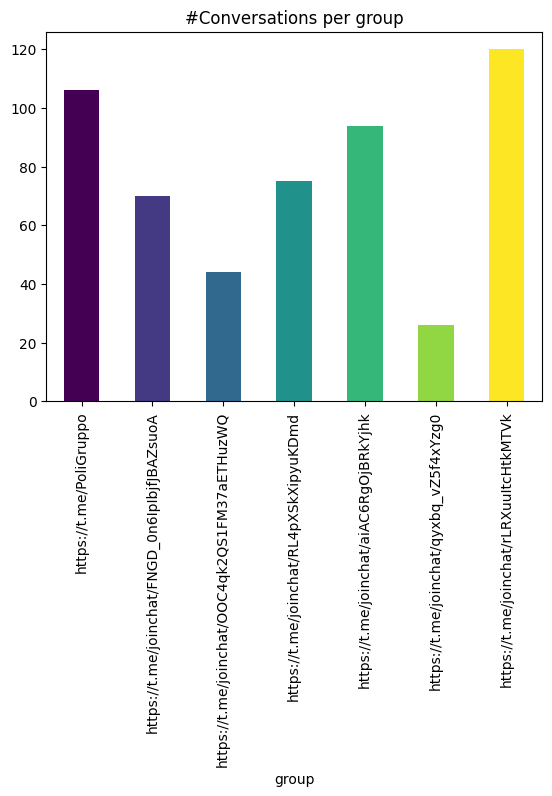

Messages per Conversations per Group in Average:
group
https://t.me/PoliGruppo                          2.830189
https://t.me/joinchat/FNGD_0n6IpIbjfJBAZsuoA     4.285714
https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ     6.795455
https://t.me/joinchat/RL4pXSkXipyuKDmd           4.000000
https://t.me/joinchat/aiAC6RgOjBRkYjhk           3.191489
https://t.me/joinchat/qyxbq_vZ5f4xYzg0          11.538462
https://t.me/joinchat/rLRXuuItcHtkMTVk           2.500000
dtype: float64


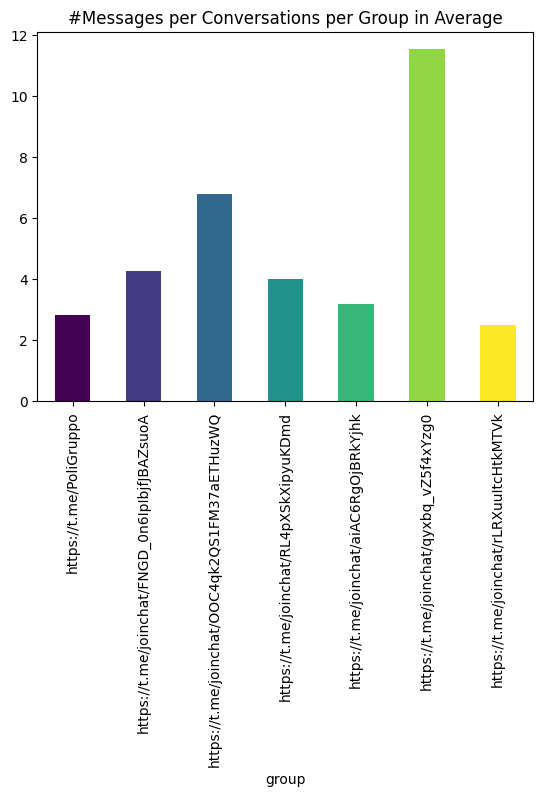

In [17]:
printstatistics(df)

### Embedding all the messages of the dataframe using LASER:

In [18]:
embeddings = embed_dataframe(df,'en')

In [19]:
embeddings.shape

(2099, 1024)

## Testing the Cosine Similaritites Method on the Original Dataset

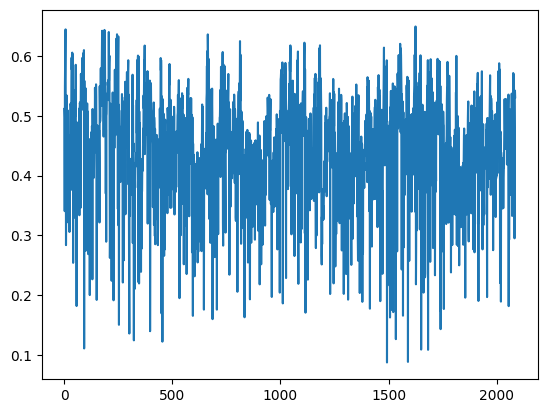

In [20]:
k1 = 12
og_similarities = cosine_similarities_last_k_sliding_window(embeddings, k1)

plt.plot(og_similarities)
plt.show()

In [21]:
treshold = find_suitable_treshold(og_similarities, df)

In [22]:
cosine_similarities_info(df, og_similarities, treshold, k1)

treshold = 0.4060000000000003

Index with the minimum cosine similarity: 
[1493]

Indices with cosine similarity below the treshold:
[14, 20, 21, 25, 29, 32, 33, 36, 43, 53, 56, 67, 68, 69, 73, 76, 82, 87, 104, 111, 114, 119, 123, 125, 130, 132, 135, 138, 142, 145, 149, 161, 162, 163, 166, 175, 204, 206, 222, 223, 224, 231, 233, 240, 260, 263, 265, 272, 280, 283, 288, 290, 295, 309, 311, 312, 313, 315, 316, 319, 320, 321, 322, 324, 329, 334, 337, 338, 339, 340, 354, 358, 361, 365, 367, 368, 369, 370, 371, 372, 398, 400, 409, 410, 422, 427, 431, 433, 435, 437, 438, 442, 445, 446, 448, 450, 462, 466, 469, 474, 476, 477, 481, 483, 484, 485, 486, 489, 494, 502, 507, 518, 522, 526, 528, 530, 543, 545, 551, 562, 565, 568, 569, 578, 587, 590, 603, 604, 606, 607, 609, 614, 615, 616, 617, 619, 621, 622, 623, 624, 625, 626, 627, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 640, 641, 642, 644, 645, 647, 648, 651, 658, 659, 662, 665, 669, 675, 683, 688, 693, 698, 704, 705, 708, 709, 710, 716,

## Pre-Processed Dataset + Statistics

### Merging consecutive messages sent by the same user in a time frame of 5 minutes

In [23]:
df.reset_index(drop=True, inplace=True)
predf, indxs, res_indxs = merge_consecutive_messages(df, 300)

#To be sure there are no duplicated instances:
print("shape before = " + str(predf.shape))
predf = predf[~predf.index.duplicated(keep='first')]
print("shape after = " + str(predf.shape))

shape before = (1866, 9)
shape after = (1866, 9)


In [24]:
pd.set_option('display.max_colwidth', None)
print("Consecutive Messages To Be Merged")
merged_messages = df.iloc[indxs][["id","reply","sender","text","conversation_id","reactions"]]
merged_messages = merged_messages[~merged_messages.index.duplicated(keep='first')]
display(merged_messages[0:10])
print("\n\nResult of the Merging:")
result_of_merging = predf.iloc[res_indxs][["id","reply","sender","text","conversation_id","reactions"]]
result_of_merging = result_of_merging[~result_of_merging.index.duplicated(keep='first')]
display(result_of_merging[0:7])

Consecutive Messages To Be Merged


,id,reply,sender,text,conversation_id,reactions
3,21749,NaN,705891914,For automation how is it?\n#Link,1,{}
4,21750,NaN,705891914,Is there any specification on which I can focus more and someone else less?,1,{}
18,21777,NaN,217022419,hello guys which one do you recommend between the two?,7,{}
19,21778,NaN,217022419,#link,7,{}
20,21779,NaN,217022419,#link,7,{}
22,21781,21771.0,137242583,"Any Windows computer plus use Linux natively, the most suitable in this case are the Dell, who have the student discount. Alternatively the Asus VivoBooks",4,{}
23,21782,NaN,137242583,For tablets and computers also look at the UNIDAYS,4,{}
26,21786,21785.0,137242583,The RAM memory is replaceable as well as the SSDs of which you have 2 slots but are small format (the 2230 instead of the classic 2280 W*L) but to open it there is to be penalized,6,{}
27,21787,NaN,137242583,"I said a bullshit, the 4050 goes as much as the old 3060 so take the asus rog",6,{}
41,21818,21817.0,137242583,"If you have no budget problems, there are content creator lines, the Asus pro art and the Zenbook Duo, the Dell Precision and some MSI (but they are not of excellent quality)",14,{}




Result of the Merging:


,id,reply,sender,text,conversation_id,reactions
3,21749,NaN,705891914,For automation how is it?\n#Link. Is there any specification on which I can focus more and someone else less?,1,{}{}
17,21777,NaN,217022419,hello guys which one do you recommend between the two?. #link. #link,7,{}{}{}
19,21781,21771.0,137242583,"Any Windows computer plus use Linux natively, the most suitable in this case are the Dell, who have the student discount. Alternatively the Asus VivoBooks. For tablets and computers also look at the UNIDAYS",4,{}{}
22,21786,21785.0,137242583,"The RAM memory is replaceable as well as the SSDs of which you have 2 slots but are small format (the 2230 instead of the classic 2280 W*L) but to open it there is to be penalized. I said a bullshit, the 4050 goes as much as the old 3060 so take the asus rog",6,{}{}
36,21818,21817.0,137242583,"If you have no budget problems, there are content creator lines, the Asus pro art and the Zenbook Duo, the Dell Precision and some MSI (but they are not of excellent quality). It seems to me anyway a great product",14,{}{}
48,21836,NaN,1112160161,You say it should be waiting for until January?. Thanks a lot anyway,18,{}{}
51,21840,21651.0,156568609,Without limits go to XPS with i9 and 4090 and you are fine for 7/8 years without having drops in exaggerated performance. Instead a PC that lasts at least 5/6 years of architecture without problems on the 1500/1600? I had seen the Dell G16 but ended,20,{}{}


### Inspect Data

In [40]:
pd.reset_option('display.max_colwidth')
predf.head()

,id,group,sender,text,reply,date,reactions,conversation_id,Unnamed: 9
0,21738,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,64987268,"guys hello everyone, I don't know if I'm in th...",NaN,2023-11-14 10:14:46+00:00,{},0,NaN
1,21739,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,962690321,/search infosec,21738.0,2023-11-14 13:10:56+00:00,{},0,NaN
2,21743,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,64987268,Thank you,NaN,2023-11-14 13:50:36+00:00,{},0,NaN
3,21749,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,705891914,For automation how is it?\n#Link. Is there any...,NaN,2023-11-16 10:04:12+00:00,{}{},1,NaN
4,21752,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,1010012648,"Hi, sorry, I would like to know if these 2 PCs...",NaN,2023-11-16 10:34:11+00:00,{},2,NaN


### Statistics:

Total Number of Conversations:
535

Total Number of Messages:
1866

Total Number of Reactions:
319

Messages per Conversation in average:
3.4878504672897197

Conversations per group:
group
https://t.me/PoliGruppo                         106
https://t.me/joinchat/FNGD_0n6IpIbjfJBAZsuoA     70
https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ     44
https://t.me/joinchat/RL4pXSkXipyuKDmd           75
https://t.me/joinchat/aiAC6RgOjBRkYjhk           94
https://t.me/joinchat/qyxbq_vZ5f4xYzg0           26
https://t.me/joinchat/rLRXuuItcHtkMTVk          120
Name: conversation_id, dtype: int64


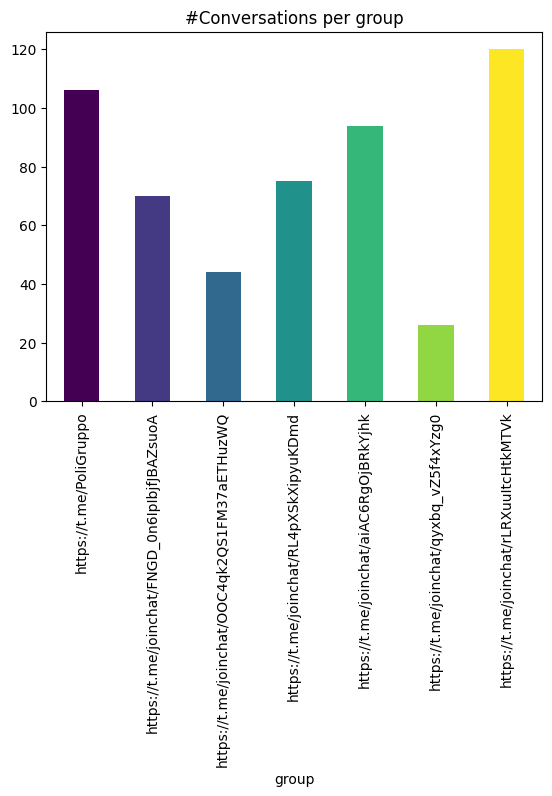

Messages per Conversations per Group in Average:
group
https://t.me/PoliGruppo                          2.584906
https://t.me/joinchat/FNGD_0n6IpIbjfJBAZsuoA     3.728571
https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ     5.704545
https://t.me/joinchat/RL4pXSkXipyuKDmd           3.560000
https://t.me/joinchat/aiAC6RgOjBRkYjhk           3.170213
https://t.me/joinchat/qyxbq_vZ5f4xYzg0          10.000000
https://t.me/joinchat/rLRXuuItcHtkMTVk           2.125000
dtype: float64


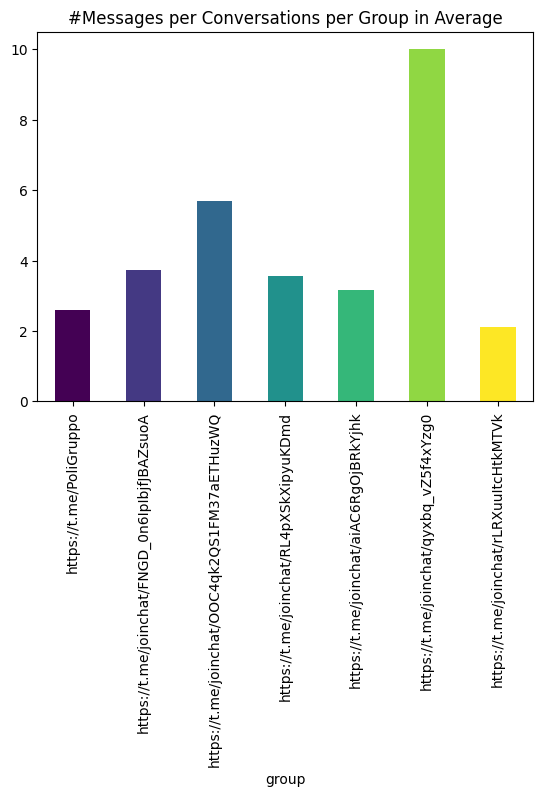

In [26]:
printstatistics(predf)

### Pre-processing phase

In [27]:
texts = [str(text) for text in predf['text']]
len(texts)

1866

The "preprocess_messages" function preprocesses all the messages by removing mentions, links, newline characters, and eliminating any empty words, preparing it for further analysis or processing.

In [28]:
pretexts = prerprocess_messages(texts)

In [29]:
watch_messages_in_a_range(pretexts, 810,815,0)

810 : What a story, thanks
811 : Dovrò ridarci un'occhiata allora
812 : Per esperienza personale dopo un po' che non viene usato webeep scede la sessione (tipo 5h o qualcosa del genere, non mi ricordo bene) L'altra cosa che potresti provare è di aprire una nuova pagina di firefox da 0, loggarti nei servizi online e salvare tutti i cookies che ci sono, questo dovrebbe permetterti di restare con gli stessi cookies con cui sei loggato anche se chiudi il browser
813 : After, if you actually keep all cookies works, you can try to remove one at a time and see when it breaks to save as little as possible
814 : How do you usually put the laptops to arrive on the market with the latest generation of installed components? Online most of the new laptops still have old components of a generation despite the fact that the new has been launched on the market since the beginning of the year.


Some messages are still in italian so we have to translate them:

In [30]:
#This instruction took 1m 32s to run on my PC
tr_pretexts = translate_texts(pretexts)

In [31]:
watch_messages_in_a_range(tr_pretexts, 810,815,0)

810 : What a story, thanks
811 : I will have to take a look at it then
812 : From personal experience after a little that we are not used WeBeep, choose the session (type 5h or something like that, I don't remember well) the other thing you could try is to open a new page of 0 Firefox, log in to online services And save all the cookies that are there, this should allow you to stay with the same cookies with which you are logged in even if you close the browser
813 : After, if you actually keep all cookies works, you can try to remove one at a time and see when it breaks to save as little as possible
814 : How do you usually put the laptops to arrive on the market with the latest generation of installed components? Online most of the new laptops still have old components of a generation despite the fact that the new has been launched on the market since the beginning of the year.


Removing all the english stopwords from the texts to remove redundant informations

In [32]:
pre_tr_pretexts = remove_stopwords_from_messages(tr_pretexts, 'english')
watch_messages_in_a_range(pre_tr_pretexts, 810,815,0)

810 : What story, thanks
811 : I take look
812 : From personal experience little used WeBeep, choose session (type 5h something like that, I remember well) thing could try open new page 0 Firefox, log online services And save cookies there, allow stay cookies logged even close browser
813 : After, actually keep cookies works, try remove one time see breaks save little possible
814 : How usually put laptops arrive market latest generation installed components? Online new laptops still old components generation despite fact new launched market since beginning year.


In [41]:
print(predf['text'][810:814])
print("\nDataframe shape:")
print(predf.shape)

810                                 What a story, thanks
811                     Dovrò ridarci un'occhiata allora
812    Per esperienza personale dopo un po' che non v...
813    After, if you actually keep all cookies works,...
Name: text, dtype: object

Dataframe shape:
(1866, 9)


#### Removing all messages with less than two words

In [42]:
new_predf = predf.copy()
new_predf['text'] = pre_tr_pretexts
print(new_predf['text'][810:814])
new_predf = new_predf[new_predf['text'].apply(lambda x: len(x.split()) > 2)]
new_predf.reset_index(drop=True, inplace=True)
print("\nNew Dataframe Shape after Removing Messages with Less than two words:")
print(new_predf.shape)

810                                   What story, thanks
811                                          I take look
812    From personal experience little used WeBeep, c...
813    After, actually keep cookies works, try remove...
Name: text, dtype: object

New Dataframe Shape after Removing Messages with Less than two words:
(1610, 9)


Total Number of Conversations:
527

Total Number of Messages:
1610

Total Number of Reactions:
270

Messages per Conversation in average:
3.0550284629981026

Conversations per group:
group
https://t.me/PoliGruppo                         100
https://t.me/joinchat/FNGD_0n6IpIbjfJBAZsuoA     70
https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ     44
https://t.me/joinchat/RL4pXSkXipyuKDmd           75
https://t.me/joinchat/aiAC6RgOjBRkYjhk           94
https://t.me/joinchat/qyxbq_vZ5f4xYzg0           26
https://t.me/joinchat/rLRXuuItcHtkMTVk          118
Name: conversation_id, dtype: int64


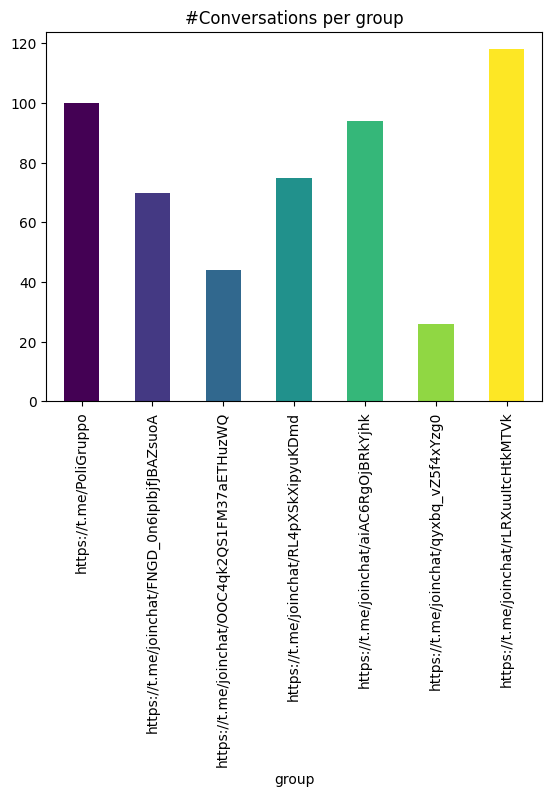

Messages per Conversations per Group in Average:
group
https://t.me/PoliGruppo                         2.280000
https://t.me/joinchat/FNGD_0n6IpIbjfJBAZsuoA    3.300000
https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ    5.136364
https://t.me/joinchat/RL4pXSkXipyuKDmd          3.120000
https://t.me/joinchat/aiAC6RgOjBRkYjhk          2.691489
https://t.me/joinchat/qyxbq_vZ5f4xYzg0          8.615385
https://t.me/joinchat/rLRXuuItcHtkMTVk          1.813559
dtype: float64


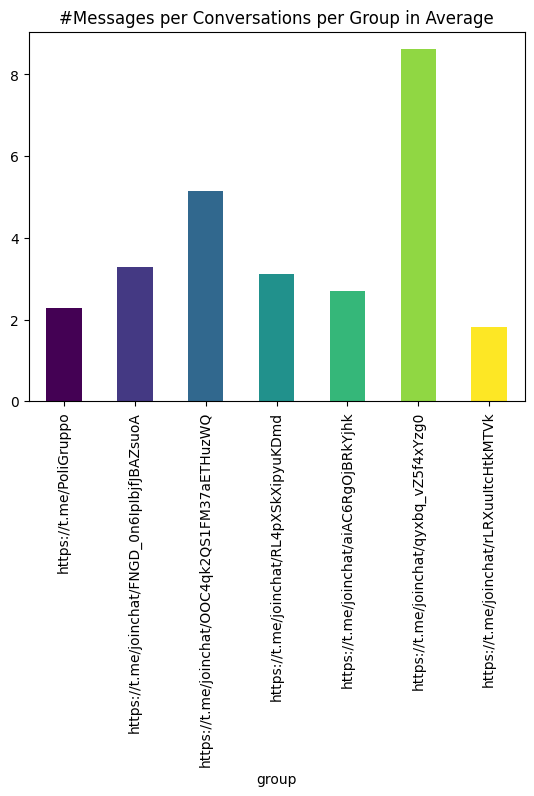

In [35]:
printstatistics(new_predf)

### Testing the Cosine Similarities Method on the Pre-Processed Dataframe

In [36]:
pre_embeddings = embed_dataframe(new_predf,'en')

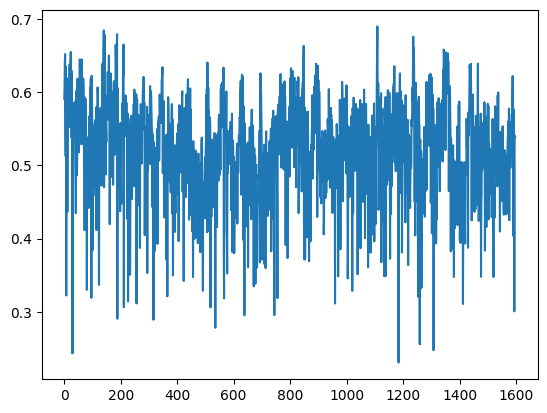

In [37]:
k2 = 12
pre_similarities = cosine_similarities_last_k_sliding_window(pre_embeddings, k2)

plt.plot(pre_similarities)
plt.show()

In [38]:
pre_treshold = find_suitable_treshold(pre_similarities, new_predf)

In [44]:
cosine_similarities_info(new_predf, pre_similarities, pre_treshold, k2)

treshold = 0.5030000000000003

Index with the minimum cosine similarity: 
[1184]

Indices with cosine similarity below the treshold:
[19, 23, 41, 43, 53, 55, 57, 82, 84, 88, 90, 92, 94, 95, 98, 99, 108, 112, 113, 115, 116, 126, 128, 132, 134, 135, 144, 153, 159, 173, 180, 185, 200, 203, 207, 209, 210, 211, 213, 214, 223, 235, 238, 240, 243, 245, 246, 247, 251, 252, 253, 257, 259, 262, 268, 271, 273, 276, 277, 280, 287, 297, 298, 306, 308, 317, 324, 328, 331, 333, 334, 337, 339, 342, 361, 365, 366, 367, 368, 370, 371, 373, 375, 376, 377, 379, 386, 388, 389, 391, 394, 397, 398, 399, 400, 401, 402, 404, 406, 407, 408, 409, 413, 417, 418, 423, 431, 435, 441, 442, 443, 446, 451, 452, 454, 459, 461, 463, 465, 468, 470, 471, 472, 474, 475, 476, 479, 480, 481, 482, 484, 485, 486, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 512, 518, 521, 523, 526, 527, 530, 532, 533, 539, 541, 542, 546, 547, 548, 550, 553, 555, 558, 562, 565, 577, 578, 58